In [489]:
import pandas as pd
%matplotlib inline
import os
from operator import attrgetter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7.0, 7.0)
os.environ["NLS_LANG"] = "American_America.AL32UTF8"

import numpy as np
import seaborn as sns

## Данные - датасет и загрузка

В современной финтех индустрии одной из ключевых сфер для применения data science является процесс кредитного скоринга.
Скоринговые модели помогают датасаентистам определить, какие клиенты с наибольшей вероятностью вернут выданный кредит, что помогает банку сформировать прибыльный продуктовый портфель и управлять рисками.

В этом кейсе вам предстоит исследовать данные о заявках клиентов на кредитную карту и кредитной истории.
- Для задания понадобятся данные из https://www.kaggle.com/rikdifos/credit-card-approval-prediction (также Вы можете найти данные [в данной папке](https://drive.google.com/drive/folders/1v5RTvwpLfYVO86KfXyfMsT3DEXb7hnCG?usp=sharing))
- Описание данных находится на страничке датасета.

In [2]:
# Загрузим файлы датасета.
app = pd.read_csv("application_record.csv", sep=",")
app.columns = map(str.lower, app.columns)

credit = pd.read_csv("credit_record.csv", sep=",")
credit.columns = map(str.lower, credit.columns)

In [255]:
app.head(3)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


In [5]:
credit.head(9)

,id,months_balance,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C


### Задание 1 - проверка качества данных
Перечислите названия колонок датасета app, в котором есть незаполненные (Null) значения.

In [41]:
info_null_app = pd.DataFrame(app.isnull().sum().values, app.isnull().sum().index)
info_null_app.index[info_null_app[0] > 0][0]

'occupation_type'

### Задание 2 - проверка качества данных
Рассчитайте долю незаполненных значений в колонке с их максимальным количеством.
Результат округлите до двух знаков после запятой (округление в большую сторону).

In [51]:
# высчитываем долю
value = (app.occupation_type.isnull().sum() * 100)/app.shape[0]
# округляем до двух знаков после запятой
round(value, 2)

30.6

### Задание 3
Определите число дубликатов в столбце с айди клиента (id)

In [464]:
app.duplicated(subset=['id']).sum()

47

### Задание 4
Определите самые популярные профессии клиентов (occupation_type), исключая Null значения, отсортировав их по числу id.

Результат представьте в виде dict вида {профессия:число клиентов}.

In [127]:
# готовим df
df_occupation_type = app[['id', 'occupation_type']].copy()
# удаляем пустые значения
df_occupation_type.dropna(inplace=True)
# удаляем дубликаты
df_occupation_type.drop_duplicates(subset=['id'], inplace=True)
# группируем и считаем кол-во клиентов
df_group_occupation_type = df_occupation_type.groupby('occupation_type').agg({'id':'count'})
# сортируем
df_group_occupation_type = df_group_occupation_type.sort_values('id', ascending=False)
# выводим в виде dict
df_group_occupation_type.to_dict()['id']

{'Laborers': 78236,
 'Core staff': 43001,
 'Sales staff': 41097,
 'Managers': 35482,
 'Drivers': 26090,
 'High skill tech staff': 17287,
 'Accountants': 15983,
 'Medicine staff': 13519,
 'Cooking staff': 8076,
 'Security staff': 7993,
 'Cleaning staff': 5843,
 'Private service staff': 3456,
 'Low-skill Laborers': 2140,
 'Secretaries': 2044,
 'Waiters/barmen staff': 1665,
 'Realty agents': 1041,
 'HR staff': 774,
 'IT staff': 604}

### Задание 5
Клиенты с каким уровнем образования (name_education_type) имеют наибольший средний доход? Помимо уровня образования укажите и средний доход для него, округленный до двух знаков после запятой.

In [165]:
# готовим df
df_education_type = app[['id', 'amt_income_total', 'name_education_type']].copy()
# удаляем дубликаты
df_education_type.drop_duplicates(subset=['id'], inplace=True)
# группируем данные и считаем средний доход
df_group_df_education_type = df_education_type.groupby('name_education_type').agg({'amt_income_total':lambda x: round(np.mean(x), 2)})
# переименование столбца
df_group_df_education_type.columns = ['highest average income']
# выводим образование с наибольшим средним доходом
df_group_df_education_type.iloc[[0]]

,highest average income
name_education_type,
Academic degree,240692.31


### Задание 6
Для клиентов с уровнем образования из п4 и семейным положением (name_family_status) Married, выясните, у кого в среднем больше доход (amt_income_total) - у клиентов с машиной или без?

In [597]:
# готовим df
df_family_status = app[['id', 'amt_income_total', 'name_education_type', 'name_family_status', 'flag_own_car']].copy()
# фильтруем df
df_family_status = df_family_status[(df_family_status.name_education_type == 'Academic degree') & (df_family_status.name_family_status == 'Married')]
# группируем и считаем средний доход
df_group_family_status = df_family_status.groupby('flag_own_car').agg({'amt_income_total':'mean'})
# выводим результат
own_car = 'без машины' if df_group_family_status.iloc[[0]].index[0] == 'N' else 'с машиной'
print(f'У клиента {own_car}, в среднем доход больше.')

У клиента без машины, в среднем доход больше.


### Задание 7
Рассчитайте разнциу между медианным стажем (days_employed) мужчин и женщин в месяцах. В ответе приведите модуль от это числа, округленный до двух знаков после запятой.

In [298]:
# готовим df
df_days_employed = app[['id', 'code_gender', 'days_employed']].copy()
# очищаем df от выбрасов в столбце days_employed
df_days_employed = df_days_employed[df_days_employed.days_employed < 0]
# дни в даты
df_days_employed['data_employed'] = df_days_employed.days_employed.apply(lambda x: pd.datetime.today() + timedelta(days=x))
# считаем кол-во месяцев
df_days_employed['quantity_month'] = (pd.to_datetime(pd.datetime.today(), format='%Y-%m').to_period('M') - df_days_employed.data_employed.dt.to_period('M')).apply(attrgetter('n'))

In [319]:
# группируем и узнаем медиану
df_days_employed = df_days_employed.groupby('code_gender', as_index=False).agg({'quantity_month': 'median'})
# назначаем переменные
F = df_days_employed['quantity_month'][df_days_employed.code_gender == 'F'][0]
M = df_days_employed['quantity_month'][df_days_employed.code_gender == 'M'][1]
# модуль от числа
abs(M-F)

12

### Задание 8
Для женщин, чей доход или стаж строго выше 75 перцентиля аналогичных показателей для мужчин, определите наиболее популярную профессию (occupation_type). Null значения в occupation_type не учитывать, как и в пункте 4.

В качесте ответа приведите название этой профессии.

In [352]:
# готовим df
df_quantile = app[['id', 'code_gender', 'days_employed', 'amt_income_total', 'occupation_type']].copy()
# удаляем пустые строчки
df_quantile.dropna(inplace=True)
# перцентиль дохода и стажа у мужчин
experience_m = df_quantile.days_employed[df_quantile.code_gender == 'M'].quantile(.75)
income_m = df_quantile.amt_income_total[df_quantile.code_gender == 'M'].quantile(.75)

# df женщин
df_famale = df_quantile[df_quantile.code_gender == 'F']
# df женщин выше 75 перцентиля чем у мужчин
df_famale = df_famale[(df_famale.days_employed < experience_m) & (df_famale.amt_income_total > income_m)]
# группировка и кол-во клиентов
df_famale = df_famale.groupby('occupation_type', as_index=False).agg({'id':'count'})
# сортировка и вывод
df_famale.sort_values('id', ascending=False).iloc[0][0]

'Managers'

### Задание 9
Оцените наличие связи между размером дохода и модулем возраста при помощи коэфициента корреляции.
В качестве ответа приведите значение в процентах, округленное до 5 знаков после запятой.

In [567]:
# готовим df
df_corr = app[['amt_income_total', 'days_birth']].copy()
# модуль деньрождения
df_corr.days_birth = df_corr.days_birth.apply(lambda x: abs(x))

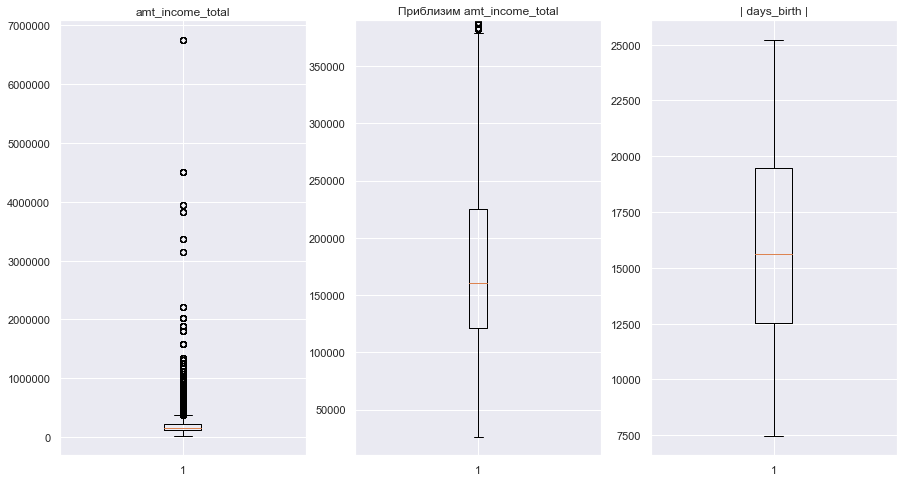

In [578]:
# проверем выбросы
fig = plt.figure(figsize=(15,8))
subplot1 = fig.add_subplot(131)
plt.boxplot('amt_income_total', data=df_corr)
plt.title('amt_income_total')

subplot1 = fig.add_subplot(132)
plt.boxplot('amt_income_total', data=df_corr)
plt.gca().set(xlim=(0, 2), ylim=(10000, 390000))
plt.title('Приблизим amt_income_total')

subplot1 = fig.add_subplot(133)
plt.boxplot('days_birth', data=df_corr)
plt.title('| days_birth |')

plt.show()

(2.0, 0.0)

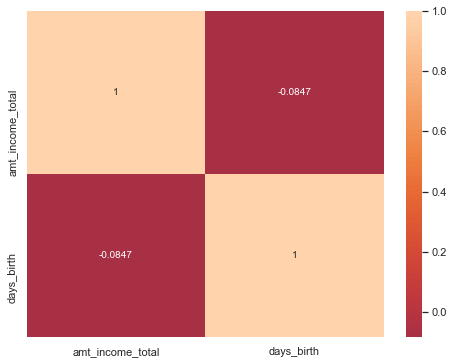

In [588]:
# убираем выбросы
df_corr = df_corr[df_corr.amt_income_total < 380000]
# строим heatmap по метрикам
plt.figure(figsize=(8,6))
ax = sns.heatmap(df_corr.corr(), center=-1, annot=True, fmt ='.4g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [603]:
# коэффициент корреляции
value = abs(round(df_corr.corr().loc['amt_income_total', 'days_birth'], 2) * 100)
print(f'{value} %')

8.0 %


### Задание 10
По результатам задания 9 при помощи коээфициента корреляции оцените силу связи между доходом и модулем возраста:

    1) сильная положительная связь
    2) слабая положительная связь
    3) нелинейная связь
    4) умеренная отрицательная связь
    5) все ответы неверны

**Выберите верный ответ:**<br>
Так как у нас слабая отрицательная связь<br> ***5) все ответы неверны***

### Задание 11
Какие типы занятости (name_income_type) встречаются среди клиентов с просрочкой от 30-59 дней? Ответ приведите в виде словаря с сортировкой по числу id:
{name_income_type:число id}

In [590]:
# подготовка df
df_all = pd.merge(credit, app, left_on='id', right_on='id', how='inner')

In [593]:
# выбираем клиентов с просрочкой от 30-59
df_name_income_type = df_all[df_all.status == '1'].copy()
# удаляем дубликаты
df_name_income_type.drop_duplicates(subset=['id'], inplace=True)
# группируем и вычисляем кол-во id
df_group_n_i_t = df_name_income_type.groupby('name_income_type').agg({'id': 'count'})
# сортируем и выводим в виде dict
df_group_n_i_t.sort_values('id').to_dict()['id']

{'Student': 1,
 'State servant': 380,
 'Pensioner': 607,
 'Commercial associate': 1057,
 'Working': 2104}

### Задание 12
Выберите верные утверждения для клиентов с просрочкой более 150 дней:

    1) среди этих клиентов больше всего людей имеет образование уровня Lower secondary
    2) среди этих клиентов 61% - мужчины
    3) не все такие клиенты присутствуют в датасете с заявками
    4) все три утверждения выше неверны

In [594]:
# подготовка df
df_delay = df_all[['id', 'name_education_type', 'code_gender', 'status']][df_all.status == '5']
# удаляем дубликаты
df_delay.drop_duplicates(subset=['id'], inplace=True)

*Проверка утверждения* **1**

In [595]:
df_group_delay = df_delay.groupby('name_education_type').agg({'id': 'count'})
df_group_delay.sort_values('id', ascending=False)

,id
name_education_type,
Secondary / secondary special,110
Higher education,57
Incomplete higher,7
Lower secondary,6


*Проверка утверждения* **2**

In [596]:
male_count = df_delay.code_gender[df_delay.code_gender == 'M'].count()

print(f"Среди этих клиентов {round((male_count * 100)/ df_delay.shape[0], 0)} % - мужчин.")

Среди этих клиентов 38.0 % - мужчин.


**Выберите верный ответ на основании расчетов выше:**<br>
4) все три утверждения выше неверны